# Import des modules

In [1]:
import string
from collections import Counter

import nltk
import pandas as pd
import numpy as np
import sklearn
import gensim
import spacy

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
#libcudart10.1

2022-12-08 09:54:32.615554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 09:54:32.615575: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 09:54:34.102130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-08 09:54:34.103187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 09:54:34.103502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

# Chargement des données
![Analyse de sentiments](https://modernmarketing.co.za/wp-content/uploads/2019/10/Developing-Customer-Centric-Strategy-Through-Automation-1-1.jpg)

In [2]:
# Dataset critiques IMDB
df_train = pd.read_csv("train.csv.gz")
df_valid = pd.read_csv("test.csv.gz")

# Explorez les données

In [3]:
df_train.head()

,text,score
0,I rented I AM CURIOUS-YELLOW from my video sto...,4
1,"""I Am Curious: Yellow"" is a risible and preten...",1
2,If only to avoid making this type of film in t...,1
3,This film was probably inspired by Godard's Ma...,2
4,"Oh, brother...after hearing about this ridicul...",1


In [4]:
df_valid.head()

,text,score
0,I love sci-fi and am willing to put up with a ...,3
1,"Worth the entertainment value of a rental, esp...",4
2,its a totally average film with a few semi-alr...,3
3,STAR RATING: ***** Saturday Night **** Friday ...,2
4,"First off let me say, If you haven't enjoyed a...",4


In [5]:
df_train.score.value_counts()

1     5100
10    4732
8     3009
4     2696
7     2496
3     2420
2     2284
9     2263
Name: score, dtype: int64

# Préparation du jeu de données

On a des critiques qui ont un score entre 1 et 10.

On va dire qu'une critique est positive si le score est plus grand que 5 et négative sinon.

Créez la colonne "positive" qui contient 0 pour les critiques négatives et 1 pour les positives

In [6]:
df_train["positive"] = df_train["score"] > 5
df_valid["positive"] = df_valid["score"] > 5

In [7]:
# Si ça passe c'est ok
nb_positives = (df_train["positive"] == 1).sum()
assert nb_positives == 12500, f"nb_positives = {nb_positives} au lieu de 12500"

# Bag Of Words preprocessing

On récupère toutes les fonctions de preprocessing pour convertir les textes en matrice de features

In [8]:
# nécessaire la 1ere fois
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

STOP_WORDS = set(stopwords.words('english'))

def extract_tokens(text):
    res = []
    for sent in nltk.sent_tokenize(text):
        res += nltk.word_tokenize(sent)
    return res

def clean_tokens(tokens):
    return [token.lower() for token in tokens if token not in string.punctuation]

def remove_stop_words(tokens):
    return [token for token in tokens if token not in STOP_WORDS]

def text2tokens(text):
    tokens = extract_tokens(text)
    tokens = clean_tokens(tokens)
    tokens = remove_stop_words(tokens)
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/charles/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/charles/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


scikit-learn a toutes les fonctionalités dont on a besoin : https://scikit-learn.org/stable/modules/classes.html?highlight=text#module-sklearn.feature_extraction.text

Utilisez ces nouveaux outils pour générer les matrices X_train et X_valid à partir de df_train["text"] et df_valid["text"]

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectoriser = TfidfVectorizer()

In [10]:
X_train = vectoriser.fit_transform(df_train["text"])

In [11]:
X_valid = vectoriser.transform(df_valid["text"])

Quelle est la taille du vocabulaire utilisé par votre vectorizer?

In [12]:
len(vectoriser.vocabulary_)

75911

In [13]:
# On prépare le vecteur à prédire
y_train = df_train["positive"]
y_valid = df_valid["positive"]

# Un peu de Machine learning

On va maintenant utiliser scikit learn pour apprendre une régression logistique sur nos données d'entrainement : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

Etape 1 : Créez le modèle

Etape 2 : fit(X, y)

Etape 3 : Evaluons les performances

Commencez par instancier le modèle

In [14]:
ml = sklearn.linear_model.LogisticRegression(max_iter=1000)

Lancez l'apprentissage sur l'ensemble de train

In [15]:
ml.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Affichez la matrice de confusion
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

Explorez les options 'normalize' : Quelle information est la plus pertinente ?

In [16]:
y_pred = ml.predict(X_valid)

## Tracez la courbe ROC
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html?highlight=roc%20curve#sklearn.metrics.plot_roc_curve


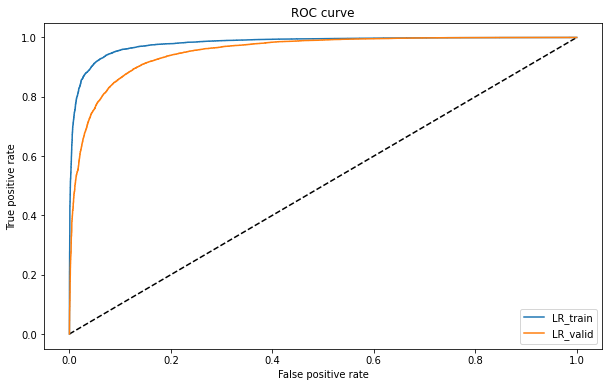

In [17]:
fpr_lr_train, tpr_lr_train, thresholds_train = sklearn.metrics.roc_curve(y_train, ml.predict_proba(X_train)[:, 1])
fpr_lr_valid, tpr_lr_valid, threshold_valid = sklearn.metrics.roc_curve(y_valid, ml.predict_proba(X_valid)[:, 1])
plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr_train, tpr_lr_train, label='LR_train')
plt.plot(fpr_lr_valid, tpr_lr_valid, label='LR_valid')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve')
plt.show()

## Calculer l'AUC : Area Under the ROC Curve
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html?highlight=auc#sklearn.metrics.auc

In [18]:
# Aire sous la courbe ROC - train
sklearn.metrics.roc_auc_score(y_train, ml.predict_proba(X_train)[:, 1])

0.9810280064000001

In [19]:
# Aire sous la courbe ROC - valid
sklearn.metrics.roc_auc_score(y_valid, ml.predict_proba(X_valid)[:, 1])

0.9526552832

## Confusion matrix and score

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_valid, y_pred)
print(cm)

print("{:.2%}".format(accuracy_score(y_valid, y_pred)))

[[11051  1449]
 [ 1479 11021]]
88.29%


# Au tour de Word2Vec

Commencez par rajouter la colonne tokens aux dataframes df_train et df_valid.
Vous allez y stocker les tokens des textes en utilisant les fonctions données en début du notebook

In [21]:
df_train["tokens"] = df_train["text"].apply(text2tokens)

In [22]:
df_valid["tokens"] = df_valid["text"].apply(text2tokens)

In [23]:
df_train["tokens"].head()

0    [rented, curious-yellow, video, store, controv...
1    [``, curious, yellow, '', risible, pretentious...
2    [avoid, making, type, film, future, film, inte...
3    [film, probably, inspired, godard, 's, masculi...
4    [oh, brother, ..., hearing, ridiculous, film, ...
Name: tokens, dtype: object

In [24]:
# Si ça passe c'est ok
assert "tokens" in df_train.columns, df_train.columns
assert "tokens" in df_valid.columns, df_valid.columns

On va utiliser gensim et sa fonction Word2Vec : https://radimrehurek.com/gensim/models/word2vec.html

Crééz un modèle appelé w2v :
 - Choisissez des vecteur de taille 300,
 - entrainez le modèle sur les tokens d'entrainement (df_train)
 - pensez à utiliser tous les cpus à votre disposition

In [25]:
%%time
w2v = gensim.models.Word2Vec(sentences=df_train["tokens"], vector_size=300, window=5, min_count=10, epochs=20, workers=4)


CPU times: user 3min 33s, sys: 1.63 s, total: 3min 35s
Wall time: 1min 10s


Est-ce que king - man + woman nous donne queen ? Oui/Non et surtout pourquoi?

indice : utilisez la méthode most_similar du modèle

In [26]:
w2v.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('furst', 0.3361091613769531),
 ('regina', 0.321591317653656),
 ('queen', 0.3185684382915497),
 ('triton', 0.30101722478866577),
 ('attila', 0.2915697991847992),
 ('solomon', 0.2858276069164276),
 ('lion', 0.2691318392753601),
 ('stephen', 0.26655054092407227),
 ('vidor', 0.26454249024391174),
 ('gator', 0.26169833540916443)]

In [27]:
queen = w2v.wv["king"] - w2v.wv["man"] + w2v.wv["woman"]

In [28]:
w2v.wv.most_similar(positive=[queen])

[('king', 0.6143055558204651),
 ('woman', 0.4675268828868866),
 ('furst', 0.33099421858787537),
 ('regina', 0.3191247880458832),
 ('queen', 0.31430143117904663),
 ('triton', 0.29867982864379883),
 ('attila', 0.28571826219558716),
 ('solomon', 0.2822919487953186),
 ('vidor', 0.2679447531700134),
 ('stephen', 0.264792263507843)]

In [29]:
queen_norm = (
    w2v.wv.get_vector("king", norm=True)
    - w2v.wv.get_vector("man", norm=True)
    + w2v.wv.get_vector("woman", norm=True)
)
w2v.wv["queen"][:10], queen[:10], queen_norm[:10]
w2v.wv.most_similar(positive=[queen_norm])

[('king', 0.6231549382209778),
 ('woman', 0.48975637555122375),
 ('furst', 0.3361091613769531),
 ('regina', 0.321591317653656),
 ('queen', 0.3185684382915497),
 ('triton', 0.30101722478866577),
 ('attila', 0.2915697395801544),
 ('solomon', 0.2858276069164276),
 ('lion', 0.2691318392753601),
 ('stephen', 0.26655054092407227)]

Explorez un peu le modèle, est-ce que vous trouvez des choses intéressantes?

La méthode doesnt_match peut être intéressante

In [30]:
w2v.wv.doesnt_match?

Signature: w2v.wv.doesnt_match(words)
Docstring:
Which key from the given list doesn't go with the others?

Parameters
----------
words : list of str
    List of keys.

Returns
-------
str
    The key further away from the mean of all keys.
File:      ~/.local/lib/python3.8/site-packages/gensim/models/keyedvectors.py
Type:      method


# Machine learning avec word2vec

Grace au modèle word2vec on est capable de transformer un mot en vecteur et ces vecteurs ont des propriétés intéressantes.

Mais on travaille avec des textes composés de plusieurs mots et de plusieurs phrases. Comment utiliser le modèle sur un texte complet.

La possibilité la plus souvent utilisée est de prendre la moyenne des vecteurs associés aux mots du texte. Voyons voir ce que ça donne comme performance vs le TF-IDF du début du TP.

Créez la fonction text2vec qui à un texte retourne le vecteur qui correspond à la moyenne des vecteurs associés aux mots du texte. (regardez la méthode mean des array numpy)

Créez la matrice d'entrainement X_train_w2v à partir de df_train et de text2vec

Créez la matrice de validation X_valid_w2v à partir de df_valid et de text2vec

On entraine une régression linéaire

On plot la matrice de confusion

On plot la courbe ROC

On calcule l'AUC

Alors Word2Vec ça résoud tout les problèmes?

# Et si on charge le word2vec de google

Il est dispo sur miriel045 : /tmp/jacq/GoogleNews-vectors-negative300.bin.gz
Copiez le sur le /tmp de votre machine, pas dans votre home! (1.5G)

Vous pouvez aussi utiliser [spacy](https://spacy.io/usage/models) en chargeant les modèles : en_core_web_md ou en_core_web_lg

Est-ce que le modèle obtenu avec ces vecteurs est plus performant que le notre? Que le TF-IDF?